In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statistics
from collections import defaultdict



## Keeping weights fixed/ weights as parameters



### 1 Dimentional Trait

#### I) **Goal:** explore how the trait varies in a population under stochastically changing environment with discrete generations

In [3]:
# Define states
states = ["Dry", "Wet"]
n_states = len(states)

# Transition probability matrix
Transition_probs = np.array([
    [0.6, 0.4],  # From Dry
    [0.4, 0.6]   # From Wet
])


# Simulate environment over time
n_gen = 1000
env_sequence = []
current_state = 0 

Env = np.array([
    [-0.9],  
    [0.2],  
 ])

#baseline maternal effect
population_size= 1000


In [7]:
def w(z_combined):
    return (np.exp(-z_combined**2 /(2))) 

def z_dist(z1, env_opt):
    x0 = env_opt
    return ((np.sqrt((x0 - z1)**2 )))

In [4]:
# Mutational effect sizes
sigma_mut=0.8
sigma_epimut=0.3
sigma_d=0.7
sigma_epsilon= 0.05

## mutation rates
mu_g= 1e-06
mu_e= 1e-03

##starting values of weights
alpha_list = np.round(np.linspace(0.01,1,10),2)
beta_list = np.round(np.linspace(0.01,1,10),2)
gamma_list = np.round(np.linspace(0.01,1,10),2)
##starting values of weights


gamma_list

# Baseline maternal effect

m0_a = 0.01

In [42]:
alpha_list

array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ])

In [5]:
z_a_t= np.random.uniform(low=-100, high=100, size=population_size) 

y_a_t = np.random.uniform(low=-0.5, high=0.5, size=population_size)



In [8]:
results = pd.DataFrame(columns=['alpha', 'beta', 'gamma', 'final_fitness'])

for alpha in alpha_list:
    for beta in beta_list:
        for gamma in gamma_list:
            # Initialize variables for the simulation
            current_state = 0  # start dry
            gen = 0

            # Initialize trait arrays (assuming initial traits are zero)
            z_a_t = np.zeros(population_size)
            y_a_t = np.zeros(population_size)

            for _ in range(1, n_gen + 1):  # run to n_gen (inclusive)
                # Environment and optima update
                current_state = np.random.choice([0, 1], p=Transition_probs[current_state])
                A0 = Env[current_state]

                # Sample noise
                epsilon_Z = np.random.normal(0, sigma_mut, population_size)
                epsilon_Y = np.random.normal(0, sigma_epimut, population_size)
                epsilon_t = np.random.normal(0, sigma_epsilon, population_size)
                d_t = np.random.normal(0, sigma_d, population_size)

                # Trait updates
                z_a_t_plus_1 = z_a_t + mu_g * epsilon_Z
                y_a_t_plus_1 = y_a_t + mu_e * epsilon_Y

                # Maternal effects
                m1_a = (A0 - (z_a_t + y_a_t))
                mt_a = (m0_a + m1_a + epsilon_t)

                # Phenotype calculation
                P_a = alpha * z_a_t_plus_1 + beta * y_a_t_plus_1 + gamma * mt_a + d_t

                # Calculate fitness
                P_com = z_dist(P_a, Env[current_state])
                fitness = w(P_com)
                
                #  record final generation fitness
                if _ == (n_gen):   #Since indexing starts at 0 in python, last gen = 999
                    mean_fitness = fitness.mean()
                    new_row = pd.DataFrame({
                        'alpha': [alpha],
                        'beta': [beta],
                        'gamma': [gamma],
                        'final_fitness': [mean_fitness]
                    })
                    results = pd.concat([results, new_row], ignore_index=True)

                # Selection step: sample next generation
                relative_fitness = fitness / P_com.mean()
                df = pd.DataFrame({
                    'A_g': z_a_t_plus_1,
                    'A_e': y_a_t_plus_1,
                    'Mat_a': mt_a,
                    'Phenotype': P_com,
                    'fitness': fitness,
                    'relative_fitness': relative_fitness
                })

                sampled_df = df.sample(n=population_size, weights=df['relative_fitness'], replace=True)

                z_a_t = sampled_df['A_g'].values
                y_a_t = sampled_df['A_e'].values
                
                    
                gen += 1


/tmp/ipykernel_22429/860468239.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


In [52]:
results.head()

,alpha,beta,gamma,final_fitness
0,0.01,0.01,0.01,0.811524
1,0.01,0.01,0.12,0.653633
2,0.01,0.01,0.23,0.707364
3,0.01,0.01,0.34,0.826174
4,0.01,0.01,0.45,0.821078


In [62]:
results_alpha = results.groupby('alpha')
results_beta = results.groupby('beta')
results_gamma = results.groupby('gamma')

NameError: name 'unique_vals_gamma' is not defined

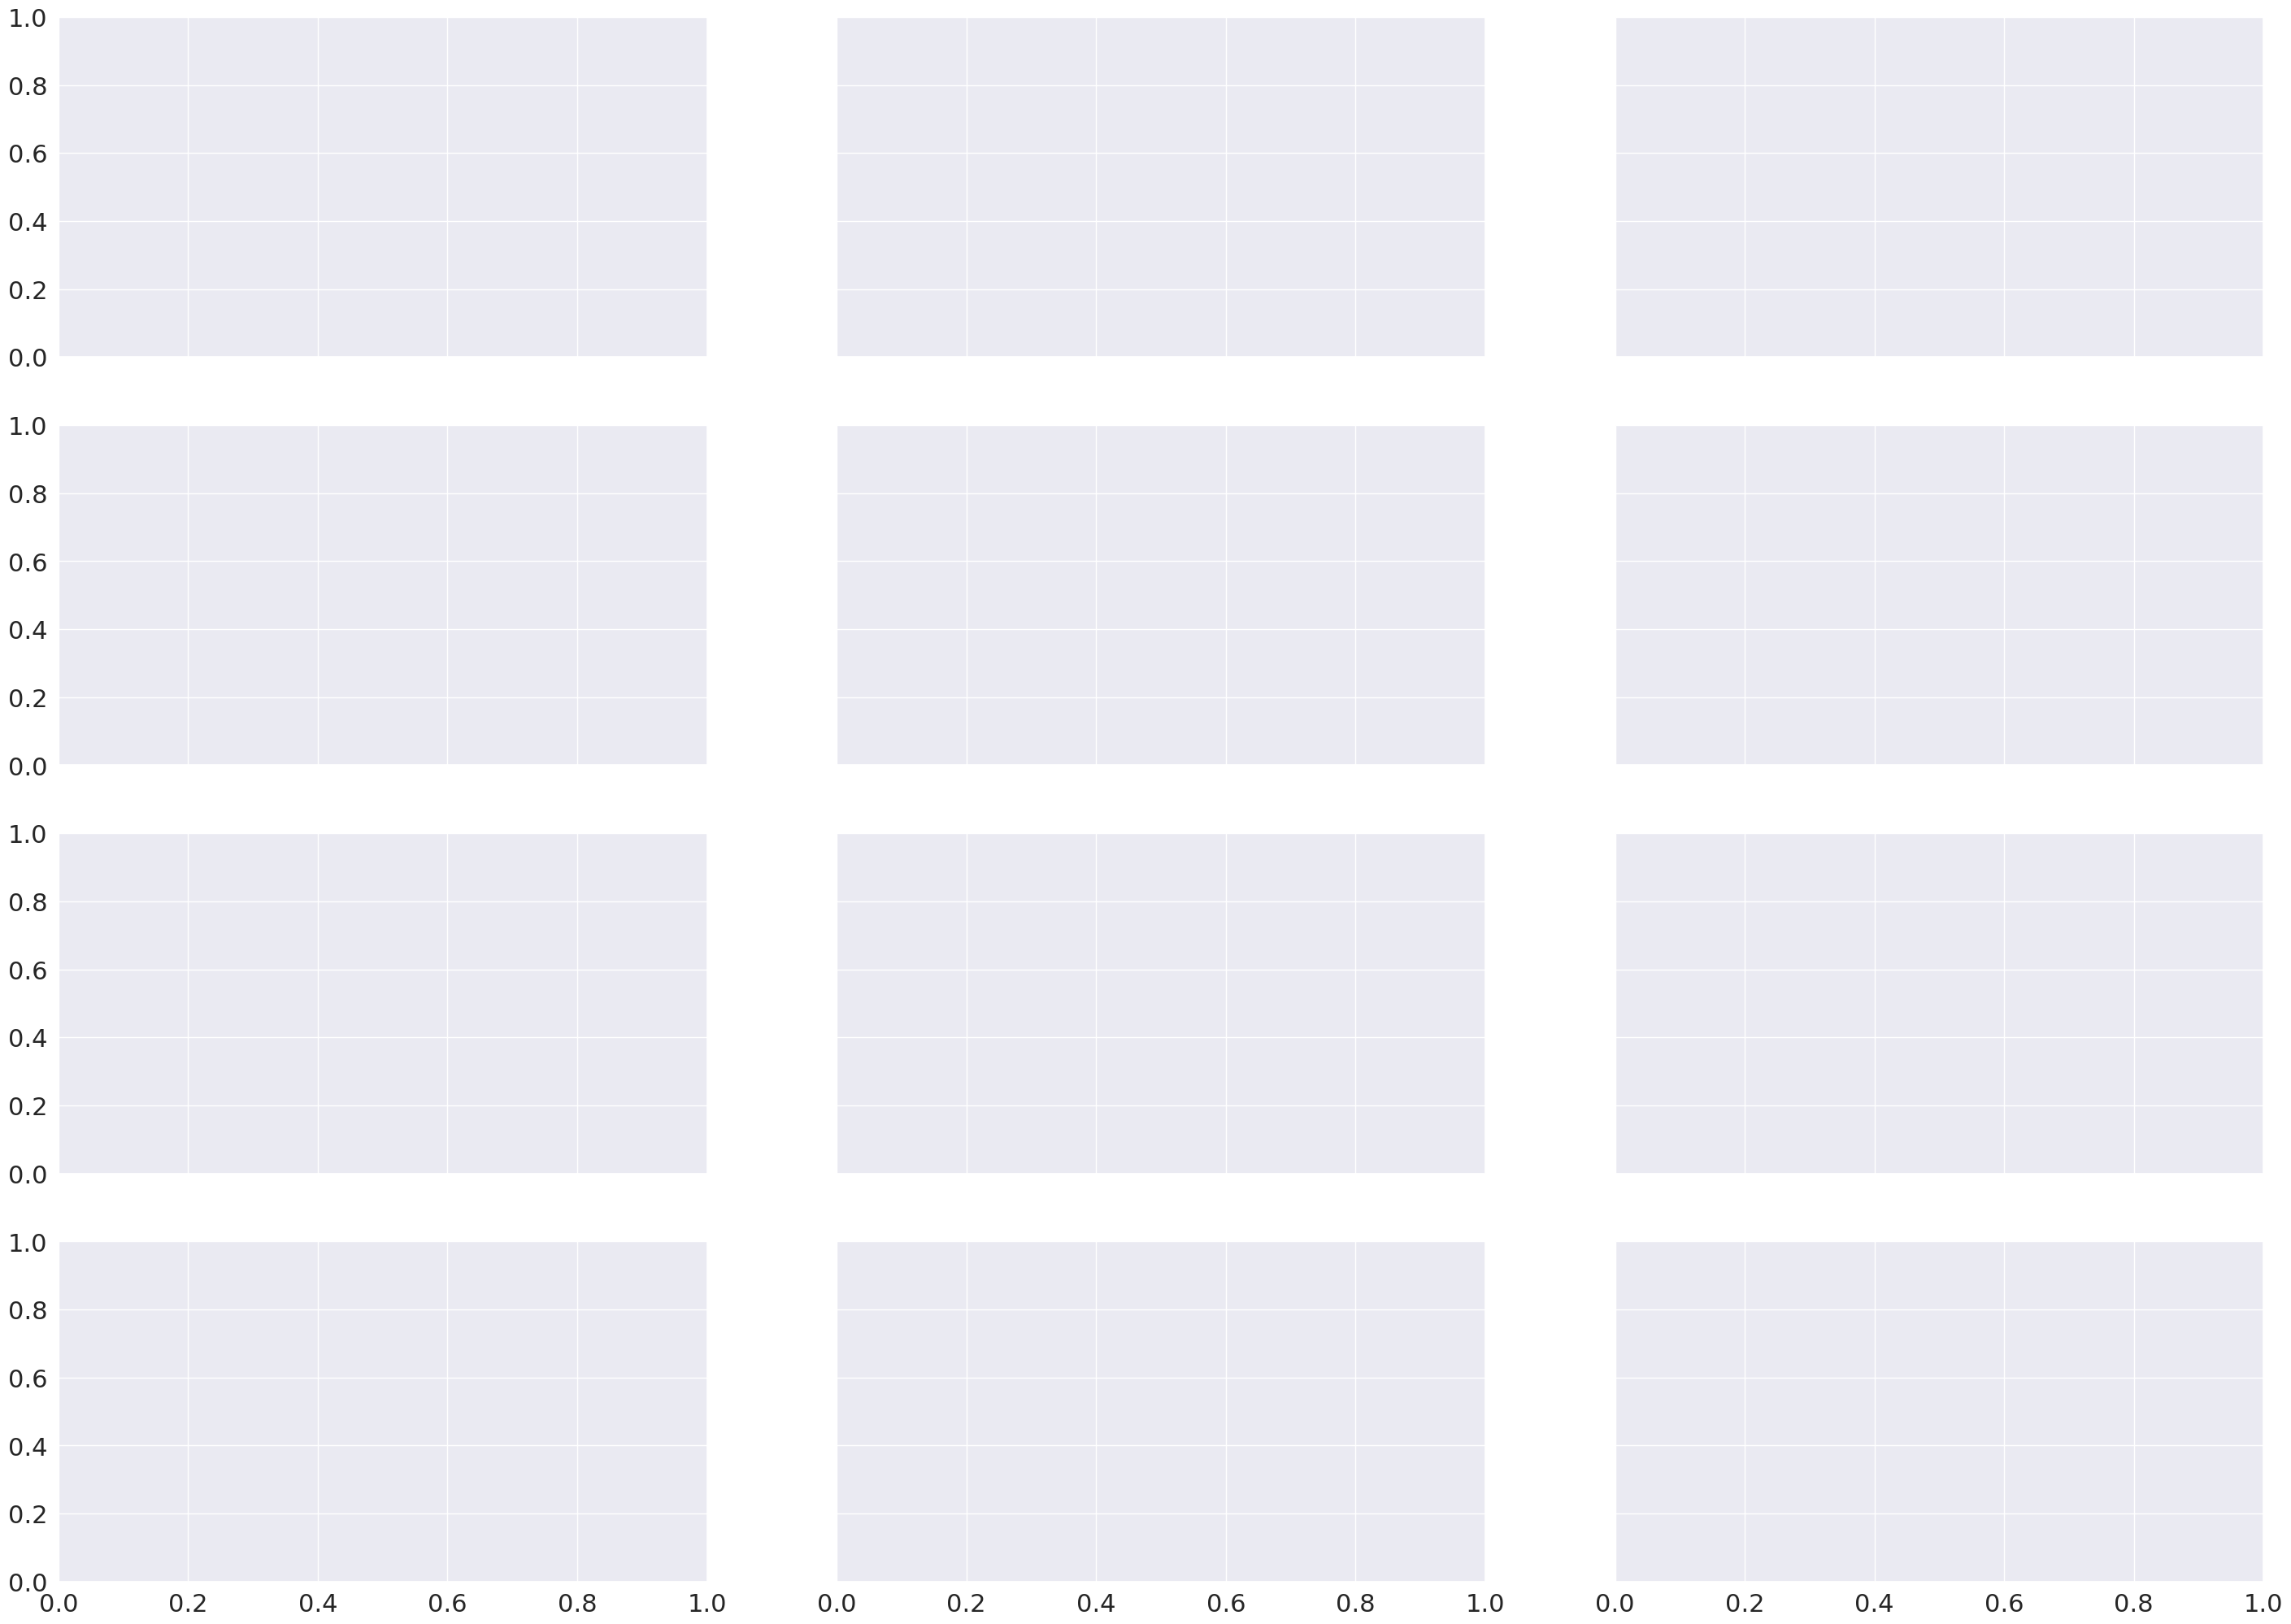

In [68]:
# Choose the colormap and normalization explicitly
cmap = sns.color_palette("viridis", as_cmap=True)

# Find min and max time values across all subsets for normalization
vmin = results['final_fitness'].min()
vmax = results['final_fitness'].max()

sns.set(font_scale=2) 
fig, axes = plt.subplots(nrows=4, ncols=3, figsize = (35,25),sharey=True, sharex=True)

for ax, val in zip(axes.flatten(),unique_vals_gamma):
    subset = results[results['gamma'] == val]
    
    # Pivot the data to matrix form: rows = col2, columns = col1, values = col4
    heatmap_data = subset.pivot(index='alpha', columns='beta', values='time')

    sns.heatmap(
        heatmap_data,
        annot=True,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        cbar_kws={'label': '# gens to 0.75 fitness'}
       # cbar=False  # Disable individual colorbars
    )
    
    ax.set_title(f'gamma = {val}')
    ax.set_xlabel('beta') #keep the axis labels inside loop
    ax.set_ylabel('alpha')  

   

In [57]:
for i, (alpha, group) in enumerate(results_alpha):
    print(groups)

NameError: name 'optimum_A_over_time' is not defined

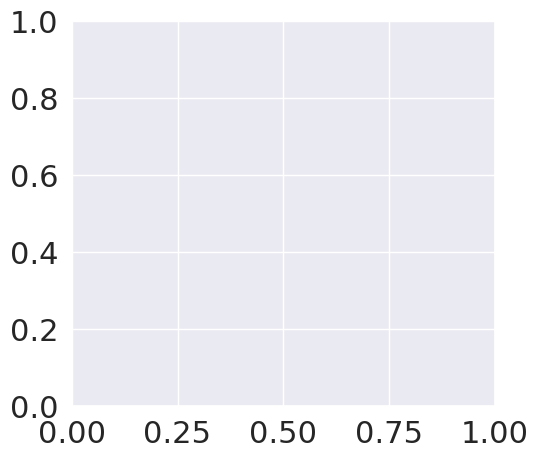

In [25]:
plt.figure(figsize=(12, 5))

# Mean Trait A comparison
plt.subplot(1, 2, 1)
plt.plot(optimum_A_over_time, label='Optimum A (100)', linestyle='--', color='blue')
plt.plot(mean_A_over_time, label='Mean Trait A (100)', color='purple',linewidth=3, alpha=0.5)
plt.title('Trait A (100 generations)')
plt.xlabel('Generation')
plt.ylabel('Trait A')
plt.grid(True)
plt.ylim(-1, 1)
plt.legend()

#### II) **Goal:** Explore no. of generations to reach 0.75 fitness for different values of weights

In [15]:

results =  pd.DataFrame(columns=['alpha','beta' ,'gamma','time'])

for alpha in alpha_list:
    for beta in beta_list:
        for gamma in gamma_list:
            # Initialize variables for the simulation
            current_state = 0  # start dry
            gen = 0
            keep_going = True

            # Initialize trait arrays (assuming initial traits are zero)
            z_a_t = np.zeros(population_size)
            y_a_t = np.zeros(population_size)

            time_to_reach_075 = None

            while gen < n_gen and keep_going:
                # Environment and optima update
                current_state = np.random.choice([0, 1], p=Transition_probs[current_state])
                A0 = Env[current_state]

                # Sample noise
                epsilon_Z = np.random.normal(0, sigma_mut, population_size)
                epsilon_Y = np.random.normal(0, sigma_epimut, population_size)
                epsilon_t = np.random.normal(0, sigma_epsilon, population_size)
                d_t = np.random.normal(0, sigma_d, population_size)

                # Trait updates
                z_a_t_plus_1 = z_a_t + mu_g * epsilon_Z
                y_a_t_plus_1 = y_a_t + mu_e * epsilon_Y

                # Maternal effects
                m1_a = (A0 - (z_a_t + y_a_t))
                mt_a = (m0_a + m1_a + epsilon_t)

                # Phenotype calculation
                P_a = alpha * z_a_t_plus_1 + beta * y_a_t_plus_1 + gamma * mt_a + d_t

                # Calculate fitness
                P_com = z_dist(P_a, Env[current_state])
                fitness = w(P_com)
                mean_fitness = fitness.mean()

                if mean_fitness > 0.80:
                    time_to_reach_075 = gen
                    keep_going = False
                    new_row = pd.DataFrame({'alpha': [alpha],'beta': [beta],'gamma': [gamma], 'time': [gen]})
                    results = pd.concat([results, new_row], ignore_index=True)

                # Selection step: sample next generation
                relative_fitness = fitness / P_com.mean()
                df = pd.DataFrame({
                    'A_g': z_a_t_plus_1,
                    'A_e': y_a_t_plus_1,
                    'Mat_a': mt_a,
                    'Phenotype': P_com,
                    'fitness': fitness,
                    'relative_fitness': relative_fitness
                })
                sampled_df = df.sample(n=population_size, weights=df['relative_fitness'], replace=True)

                z_a_t = sampled_df['A_g'].values
                y_a_t = sampled_df['A_e'].values

                gen += 1

            if time_to_reach_075 is None:
                time_to_reach_075 = "Max_gen"  



The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/tmp/ipykernel_16102/402557213.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


In [8]:
results_numeric = results.apply(pd.to_numeric)

In [13]:
grouped_alpha= results.groupby('alpha')
grouped_beta= results.groupby('beta')
grouped_gamma= results.groupby('gamma')
unique_vals_gamma = results_numeric['gamma'].unique()  

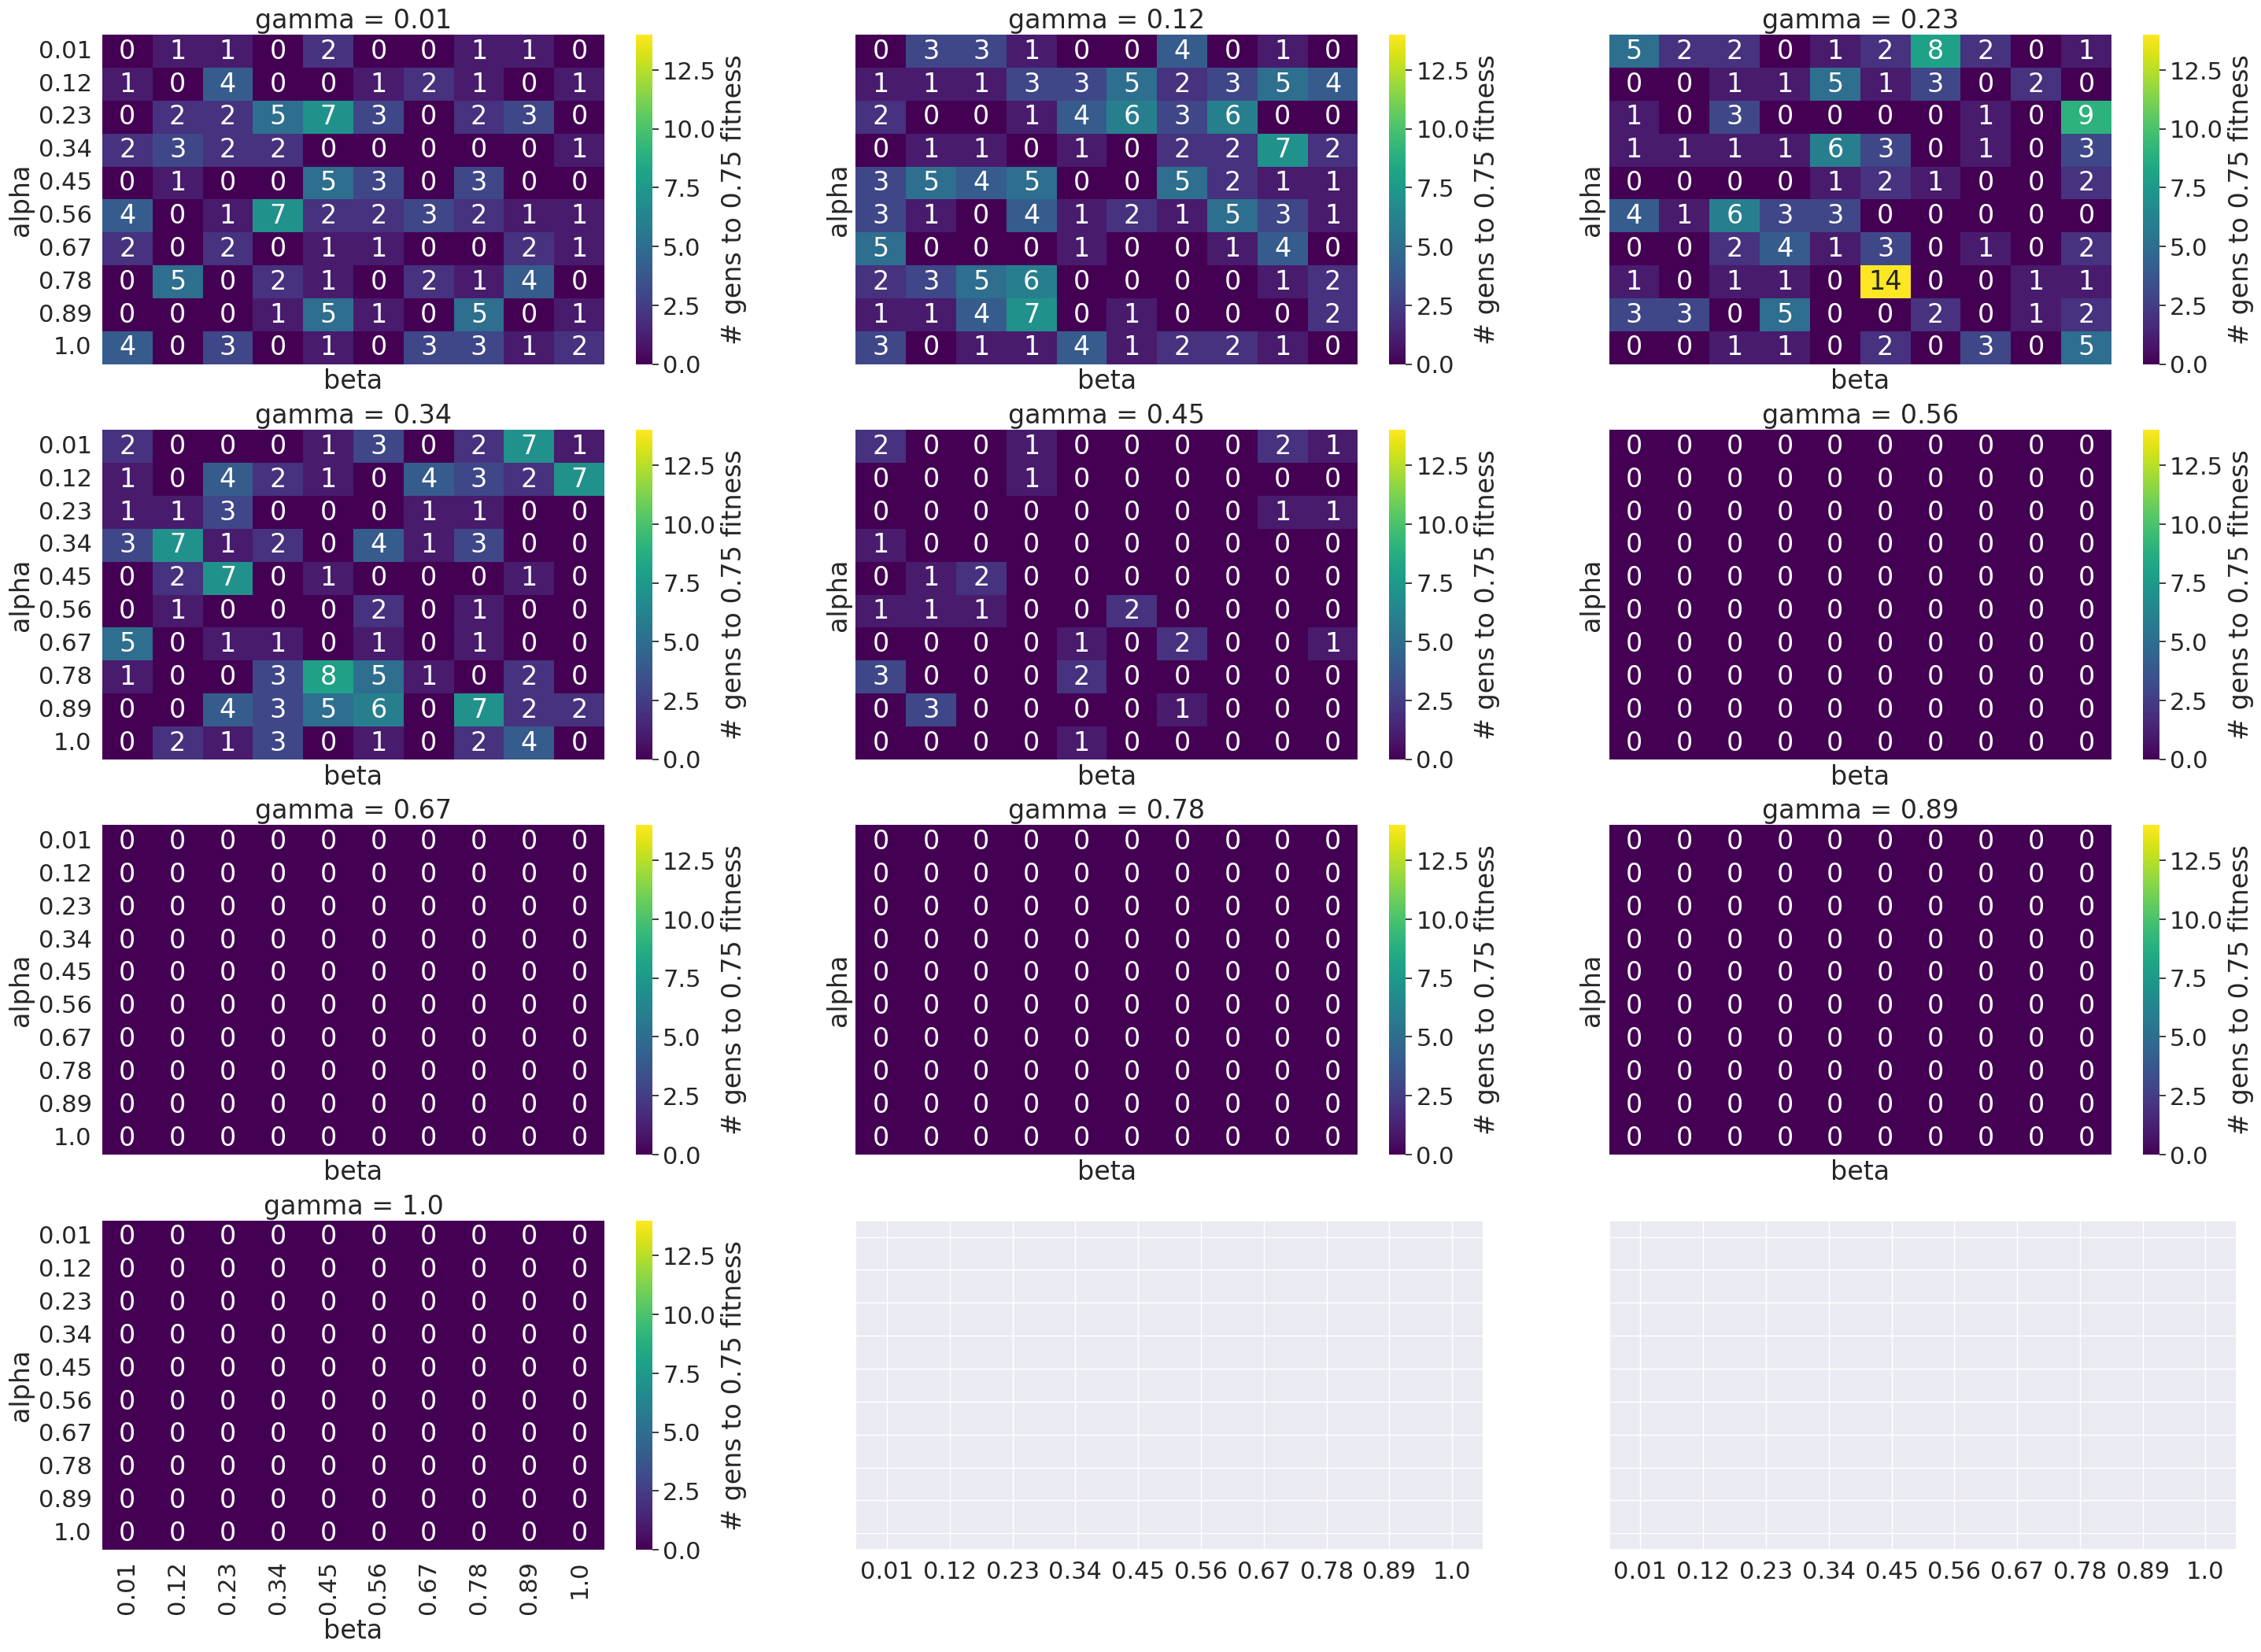

In [14]:

# Choose the colormap and normalization explicitly
cmap = sns.color_palette("viridis", as_cmap=True)

# Find min and max time values across all subsets for normalization
vmin = results_numeric['time'].min()
vmax = results_numeric['time'].max()

sns.set(font_scale=2) 
fig, axes = plt.subplots(nrows=4, ncols=3, figsize = (35,25),sharey=True, sharex=True)

for ax, val in zip(axes.flatten(),unique_vals_gamma):
    subset = results_numeric[results_numeric['gamma'] == val]
    
    # Pivot the data to matrix form: rows = col2, columns = col1, values = col4
    heatmap_data = subset.pivot(index='alpha', columns='beta', values='time')

    sns.heatmap(
        heatmap_data,
        annot=True,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        cbar_kws={'label': '# gens to 0.75 fitness'}
       # cbar=False  # Disable individual colorbars
    )
    
    ax.set_title(f'gamma = {val}')
    ax.set_xlabel('beta') #keep the axis labels inside loop
    ax.set_ylabel('alpha')  



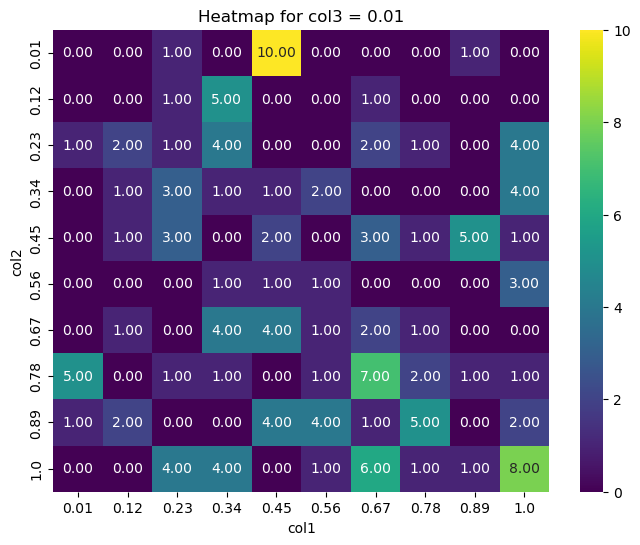

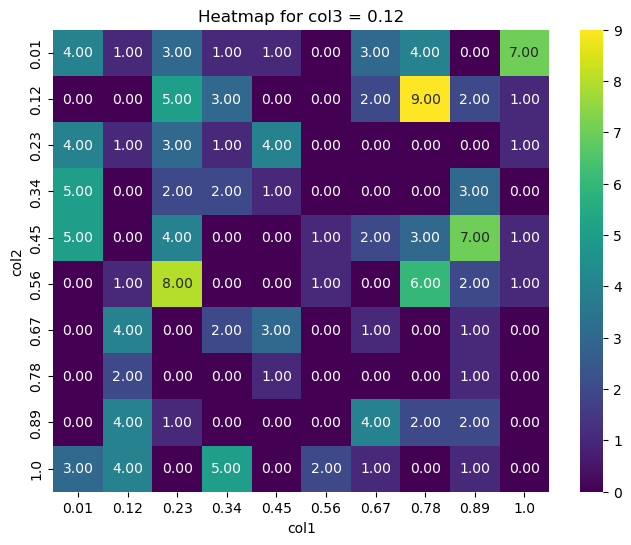

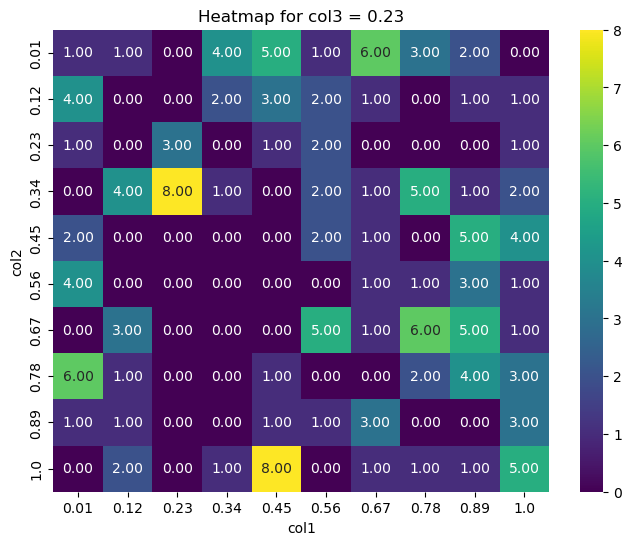

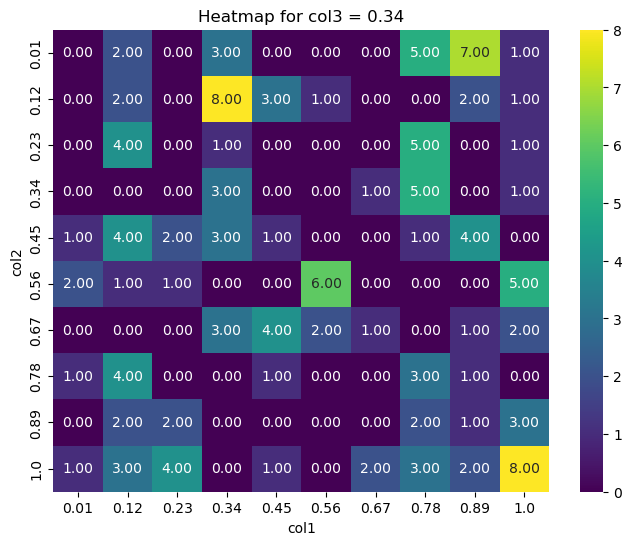

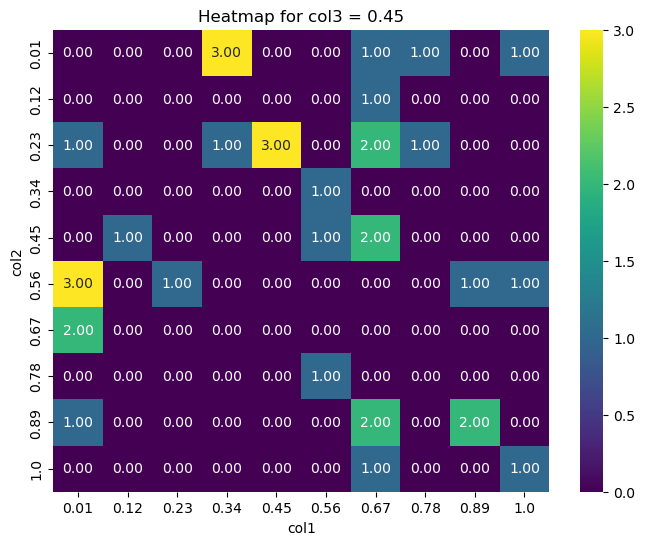

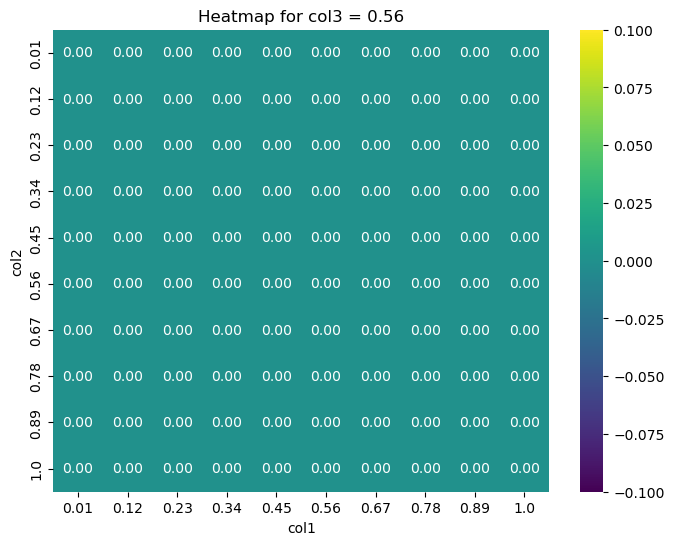

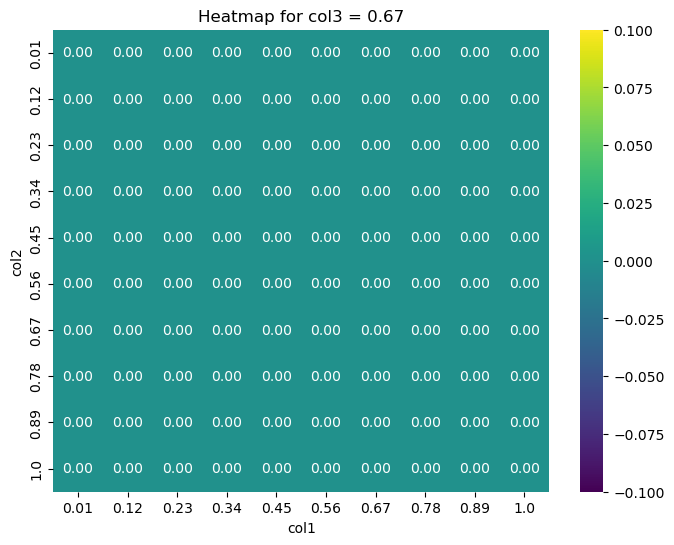

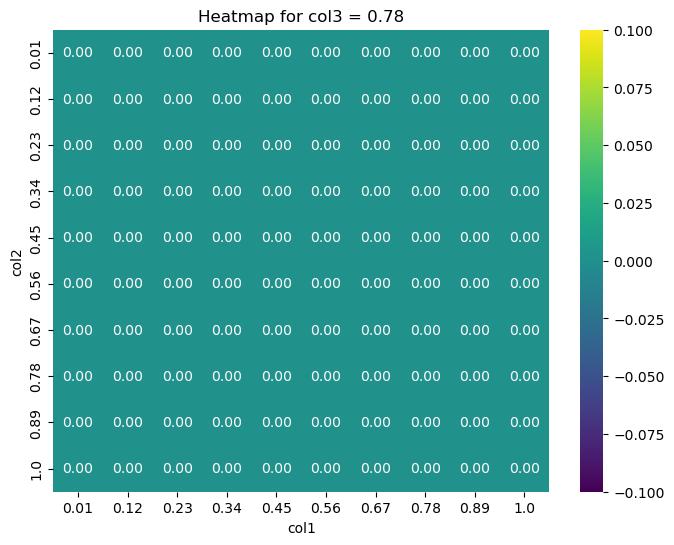

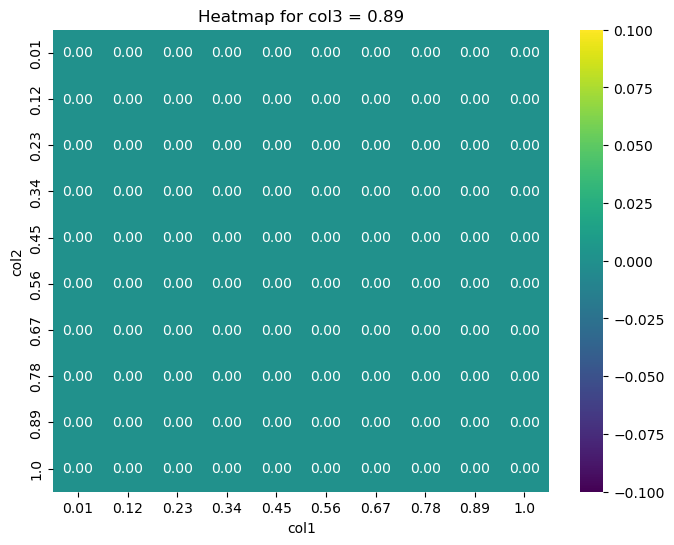

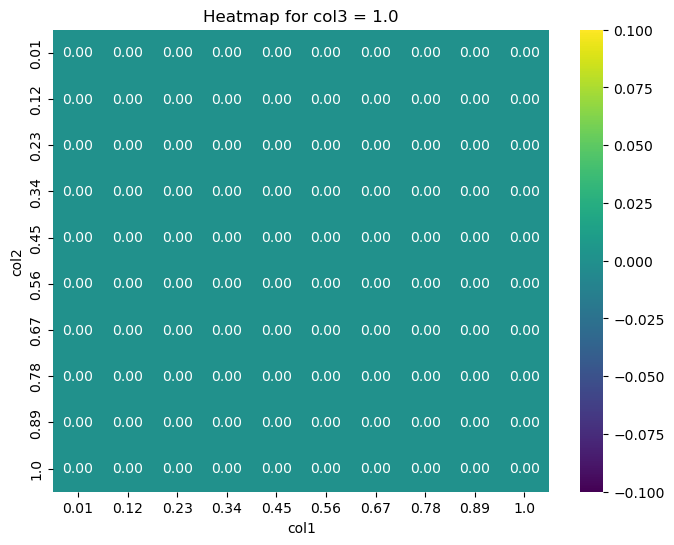

In [162]:


# Suppose your dataframe is named df and columns are ['col1', 'col2', 'col3', 'col4']

# Select 10 unique values from col3
unique_vals_gamma = results_numeric['gamma'].unique()  


fig = plt.figure()
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

for val in unique_vals_gamma:
    subset = results_numeric[results_numeric['gamma'] == val]
   

    # Pivot the data to matrix form: rows = col2, columns = col1, values = col4
    heatmap_data = subset.pivot(index='alpha', columns='beta', values='time',ax=ax)

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='viridis')
    plt.title(f'Heatmap for col3 = {val}')
    plt.xlabel('col1')
    plt.ylabel('col2')
    plt.show()


Miscellaneous code

In [1]:
#trial 

my_dict = {}

for i in range(5):
    my_dict[f"key_{i}"] = i * 2

print(my_dict)


{'key_0': 0, 'key_1': 2, 'key_2': 4, 'key_3': 6, 'key_4': 8}


In [ ]:
import pandas as pd

# Create an empty DataFrame with columns
df = pd.DataFrame(columns=['Name', 'Age'])

# Data to add (could be from anywhere, like a loop over some data source)
data_to_add = [
    ('Alice', 25),
    ('Bob', 30),
    ('Charlie', 35)
]

# Add each row via a loop
for name, age in data_to_add:
    # Create a new DataFrame with a single row to append
    new_row = pd.DataFrame({'Name': [name], 'Age': [age]})
    # Append the row to the original DataFrame
    df = pd.concat([df, new_row], ignore_index=True)

print(df)
